### Урок 5. #Задача оттока: варианты постановки, возможные способы решения##

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test/val
X, X_val, y, y_val = train_test_split(df, df['Exited'], test_size=0.2, random_state=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
3145,1,0
9767,0,1
2643,0,1


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [12]:
model_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 12)),
])

model_aboost = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(random_state = 12)),
])

Обучим модель

In [13]:
#обучим наши пайплайны
model_logreg.fit(X_train, y_train)
model_aboost.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds_logreg = model_logreg.predict_proba(X_test)[:, 1]
preds_aboost = model_aboost.predict_proba(X_test)[:, 1]
preds_logreg[:10], preds_aboost[:10]

(array([0.60058799, 0.05910799, 0.05198911, 0.1133247 , 0.36695881,
        0.07944056, 0.27623718, 0.57890357, 0.16106591, 0.07875941]),
 array([0.50731876, 0.4873337 , 0.48895529, 0.49325513, 0.4892164 ,
        0.48640387, 0.49398119, 0.50480387, 0.48357217, 0.48400409]))

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

Aboost
Roc_Auc = 0.8431247571872572
Best Threshold=0.496403, F-Score=0.597, Precision=0.578, Recall=0.618

Confusion matrix, without normalization
[[1396  188]
 [ 160  256]]


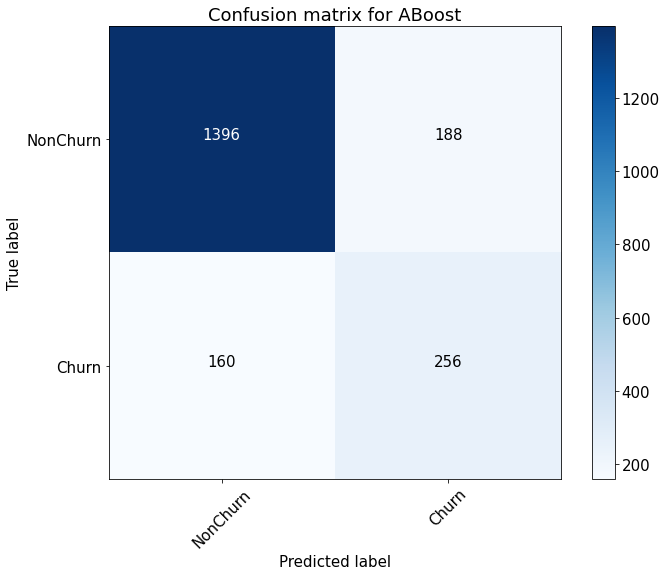

In [16]:
# Aboost
print('Aboost')

precision, recall, thresholds = precision_recall_curve(y_test, preds_aboost)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore[~np.isnan(fscore)])
aboost_threshold = thresholds[ix]
print(f'Roc_Auc = {roc_auc_score(y_test, preds_aboost)}')
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

# Отрисуем матрицу ошибок
print()
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_aboost>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for ABoost')
plt.savefig("conf_matrix.png")
plt.show()

LogReg
Roc_Auc = 0.8431247571872572
Best Threshold=0.281665, F-Score=0.533, Precision=0.486, Recall=0.589

Confusion matrix, without normalization
[[1325  259]
 [ 172  244]]


<ipython-input-17-17209000da2c>:6: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


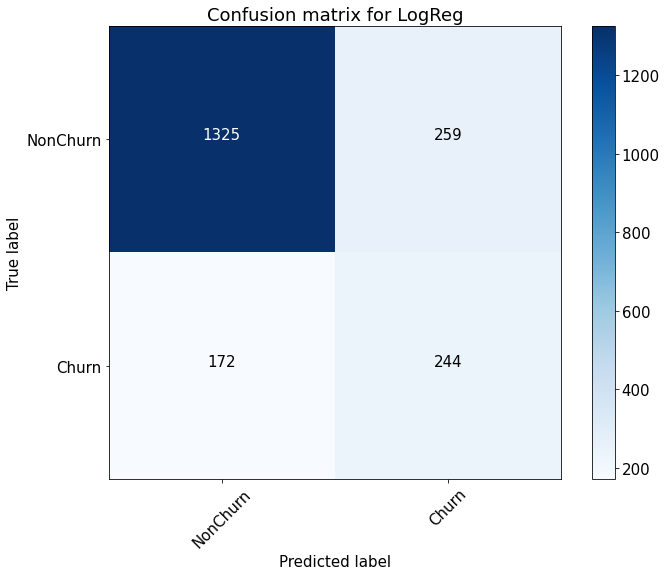

In [17]:
# LogReg
print('LogReg')

precision, recall, thresholds = precision_recall_curve(y_test, preds_logreg)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore[~np.isnan(fscore)])
print(f'Roc_Auc = {roc_auc_score(y_test, preds_aboost)}')
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

# Отрисуем матрицу ошибок
print()
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_logreg>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for LogReg')
plt.savefig("conf_matrix.png")
plt.show()

Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1463  160]
 [ 149  228]]


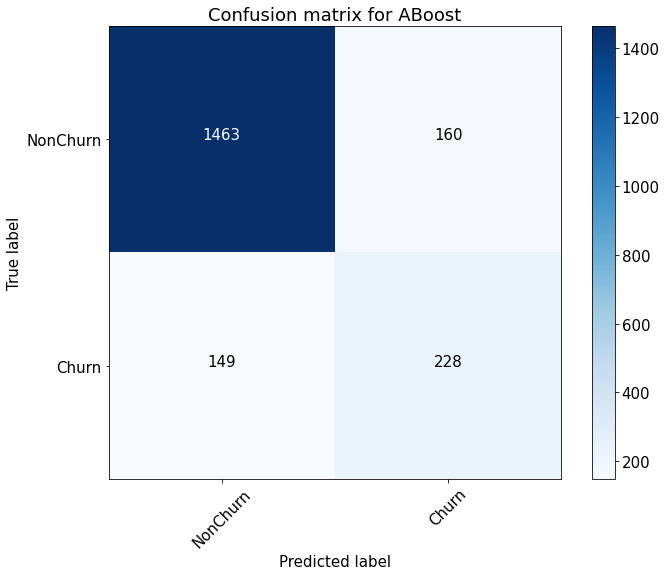

In [18]:
val_preds_aboost = model_aboost.predict_proba(X_val)[:, 1]
    
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, val_preds_aboost>aboost_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix for ABoost')
plt.savefig("conf_matrix.png")
plt.show()

# Думаю в данном случае лучше ориентироваться на ROC-AUC, хотя бы потому, что у нас нет информации по поводу значимости ошибок.

---

# Экономическая оценка

#### Пусть:
 - стоимость удержания - 1$
 
 - прибыль с удержаных – 2$
 
 
 
 - Взаимодействовали с лишними – FP (cnf_matrix[0][1])
 - пропустили ушедших – FN (cnf_matrix[1][0])
 - удержали уходяших – TN (cnf_matrix[1][1])

In [19]:
# Прибыль с использованием ML
print('Прибыль с использованием ML:\n')
# Траты на удержание
expense = (cnf_matrix[1][1] + cnf_matrix[0][1])
print(f'Траты на удержание: {expense}$')

# Прибыль с удержаных
profit = (cnf_matrix[0, 0] + cnf_matrix[1, 1])*2
print(f'Прибыль с удержаных: {profit}$')

print(f'Итого: {profit-expense}$ - потенциальная прибыль от потерянных клиентов({(cnf_matrix[1][0])}) = {profit-expense - (cnf_matrix[1][0])*2}$')

Прибыль с использованием ML:

Траты на удержание: 388$
Прибыль с удержаных: 3382$
Итого: 2994$ - потенциальная прибыль от потерянных клиентов(149) = 2696$


In [20]:
# Прибыль при отсутствии удержания
print('Прибыль при отсутствии удержания:\n')
# Траты на удержание
expense = 0
print(f'Траты на удержание: {expense}$')

# Прибыль с удержаных
profit = (cnf_matrix[0][0] + cnf_matrix[0][1])*2
print(f'Прибыль с удержаных: {profit}$')

print(f'Итого: {profit-expense}$ - потенциальная прибыль от потерянных клиентов({(cnf_matrix[1][1] + cnf_matrix[0][1])}) = {profit-expense - (cnf_matrix[1][1] + cnf_matrix[0][1])*2}$')

Прибыль при отсутствии удержания:

Траты на удержание: 0$
Прибыль с удержаных: 3246$
Итого: 3246$ - потенциальная прибыль от потерянных клиентов(388) = 2470$


In [21]:
# Прибыль при удержании всех пользователей
print('Прибыль при удержании всех пользователей:\n')
# Траты на удержание
expense = (cnf_matrix[0][0] + cnf_matrix[0][1] + cnf_matrix[1][1] + cnf_matrix[1][0])*1
print(f'Траты на удержание: {expense}$')

# Прибыль с удержаных
profit = (cnf_matrix[0][0] + cnf_matrix[0][1] + cnf_matrix[1][1] + cnf_matrix[1][0])*2
print(f'Прибыль с удержаных: {profit}$')

print(f'Итого: {profit-expense}$ - потенциальная прибыль от потерянных клиентов({0}) = {profit-expense - (0)*2}$')

Прибыль при удержании всех пользователей:

Траты на удержание: 2000$
Прибыль с удержаных: 4000$
Итого: 2000$ - потенциальная прибыль от потерянных клиентов(0) = 2000$


In [22]:
def business_threshold_calibrate(y_test, y_score, rubl_to_retention = 1, rubl_for_people = 2):
    opt_result = - np.inf

    n = 200
    for buisness_tr in np.linspace(0,1,n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (buisness_tr))
        #print(cnf_matrix)
        
        # Траты на удержание
        expense = (cnf_matrix[1][1] + cnf_matrix[0][1])*rubl_to_retention

        # Прибыль с удержаных
        profit = (cnf_matrix[0, 0] + cnf_matrix[1, 1])*rubl_for_people

        result = profit-expense-(cnf_matrix[1][0])*rubl_for_people
        

        #print(opt_buisness_tr, r2_r3)
        if (opt_result < result):
            
            opt_result = result
            opt_buisness_tr = buisness_tr
    
    
    
    font = {'size' : 15}
    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>opt_buisness_tr)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    
    # Прибыль с использованием ML
    print('Прибыль с использованием ML(opt):\n')
    # Траты на удержание
    expense = (cnf_matrix[1][1] + cnf_matrix[0][1])
    print(f'Траты на удержание: {expense}$')

    # Прибыль с удержаных
    profit = (cnf_matrix[0, 0] + cnf_matrix[1, 1])*2
    print(f'Прибыль с удержаных: {profit}$')

    print(f'Итого: {profit-expense}$ - потенциальная прибыль от потерянных клиентов({(cnf_matrix[1][0])}) = {profit-expense - (cnf_matrix[1][0])*2}$')
    return opt_buisness_tr

Confusion matrix, without normalization
[[1591   32]
 [ 237  140]]


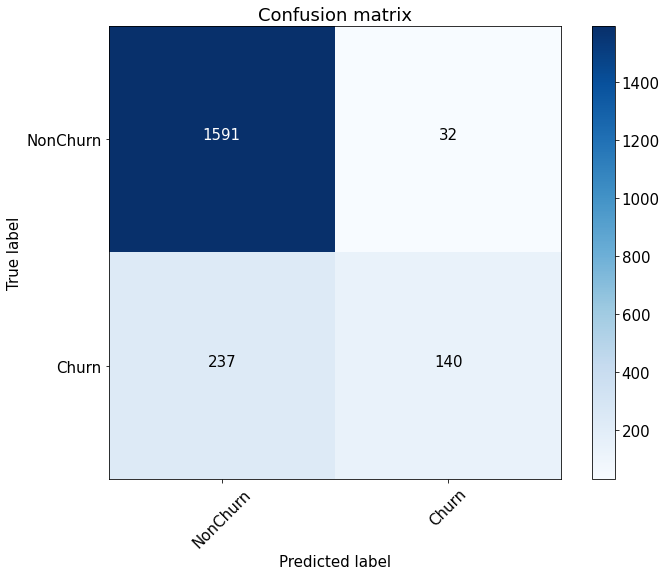

Прибыль с использованием ML(opt):

Траты на удержание: 172$
Прибыль с удержаных: 3462$
Итого: 3290$ - потенциальная прибыль от потерянных клиентов(237) = 2816$


0.5025125628140703

In [23]:
business_threshold_calibrate(y_val, val_preds_aboost, rubl_to_retention = 1, rubl_for_people = 2)

# Помогите, может есть более стабильные метрики бизнес показателей?
То что получилось у меня не может оценить сколько еще может принести клиент,  но в случае, если не использовать потенциальную прибыль от ушедших клиентов, получается что лучше впринципе никого не удерживать (хотя это не так, ведь клиентов уйдет много и в дальнейшем мы потеряем больше, чем получили сейчас)

Пример:

In [24]:
# Прибыль с использованием ML
print('Прибыль с использованием ML:\n')
# Траты на удержание
expense = (cnf_matrix[1][1] + cnf_matrix[0][1])
print(f'Траты на удержание: {expense}$')

# Прибыль с удержаных
profit = (cnf_matrix[0, 0] + cnf_matrix[1, 1])*2
print(f'Прибыль с удержаных: {profit}$')

print(f'Итого: {profit-expense}$')

Прибыль с использованием ML:

Траты на удержание: 388$
Прибыль с удержаных: 3382$
Итого: 2994$


In [25]:
# Прибыль при отсутствии удержания
print('Прибыль при отсутствии удержания:\n')
# Траты на удержание
expense = 0
print(f'Траты на удержание: {expense}$')

# Прибыль с удержаных
profit = (cnf_matrix[0][0] + cnf_matrix[0][1])*2
print(f'Прибыль с удержаных: {profit}$')

print(f'Итого: {profit-expense}$')

Прибыль при отсутствии удержания:

Траты на удержание: 0$
Прибыль с удержаных: 3246$
Итого: 3246$
